# "Band diagram"

In this chapter, we'll explore how to use femwell for more accurate waveguide modeling. Unlike simpler analytical models, FEMWELL allows us to solve Maxwell's equations directly on the waveguide geometry.

Using femwell, you can mesh any component cross-section and solve PDEs with its powerful mode solver. Unlike other solvers that rely on predefined geometries, femwell works directly with the actual component geometry. You can compute the modes of a GDSFactory cross-section, which internally defines a "uz" mesh perpendicular to a straight component using the provided cross-section.

1. import all the necessary packages:

In [6]:
import doModels.RefractiveIndex as ri
from doModels import fem, PhotonicStack

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


2. Define photonic stack:


In [7]:
stack = PhotonicStack.create(
    total_film_thickness=0.210,
    etch_depth=0.210,
    top_width=0.450,
    side_wall_angle=0,
    top_oxide_thickness=2.0,
    bottom_oxide_thickness=2.0,
)

3. Define simulation paramaters: a range of waveguide widths, wavelength, etc


In [8]:

wavelength = 1.55
num_modes = 8
widths = np.linspace(0.1, 2.5, 100)

core_index = ri.silicon(wavelength)
box_index = ri.silica(wavelength)
clad_index = ri.silica(wavelength)

all_neffs = np.zeros((widths.shape[0], num_modes))
all_te_fracs = np.zeros((widths.shape[0], num_modes))


4. Run the FEM


In [9]:
for i, width in enumerate(tqdm(widths)):

    stack.top_width.target = width
    m = fem.mesh_waveguide(total_film_thickness=stack.total_film_thickness.target,
        etch_depth=stack.etch_depth.target,
        top_width=stack.top_width.target,
        side_wall_angle=stack.side_wall_angle.target, show_plot=False)

    modes = fem.fem_waveguide(mesh=m, n_core=ri.silicon, n_clad=ri.silica, n_box=ri.silica, wavelength=wavelength, num_modes=num_modes)
    # print(n_.shape)
    all_neffs[i] = np.real([mode.n_eff for mode in modes])
    all_te_fracs[i, :] = [mode.te_fraction for mode in modes]


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


5. Plot 


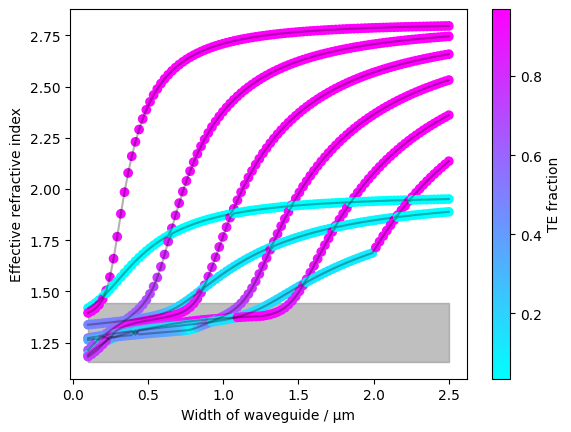

In [10]:

all_neffs = np.real(all_neffs)
plt.xlabel("Width of waveguide / µm")
plt.ylabel("Effective refractive index")
plt.fill_between(widths, 0.8*1.444, 1.444, alpha=0.5, color="gray")
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    plt.plot(widths, lams, color='black', alpha=0.3)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")
plt.colorbar().set_label("TE fraction")
plt.show()
